# Hexosaminidase Assay Analysis Notebook

This notebook analyzes raw data from the hexosaminidase degranulation assay. This enzyme activity assay measures beta-hexosaminidase levels in cell culture supernatant. Because beta-hexosaminidase is typically released from mast cells and granulocytes during the process of degranulation, an increase in the beta-hexosaminidase level can indicate that cells have degranulated.

### Inputs
The input data from this notebook are a raw data file (`data_filename`) from a plate reader and a sample manifest (`manifest_filename`), which is filled out by the experimenter for each experiment. Other parameters defined by the user include the names of the assay controls (`standard_vals` and `blank`) from the sample manifest and the name of the experiment (`experiment_name`), which is used for plot labels.

### Outputs
The notebook uses the name of the data file to create a subdirectory for the experiment in the directory `output_files` by the same name. It then parses the input data file into metadata and well-by-well data and uses the sample manifest to generate a processed dataset csv where data are labeled and blank-subtracted. It also generates two plots, one for standard values and one for experimental analytes, which are saved as png files. Finally, the notebook performs statistical analysis and generates one-way ANOVA results and Tukey HSD comparisons. The latter is saved as a csv file.

In [1]:
import os
from collections import defaultdict

import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# Parameterization.

data_filename = "../data_files/20250205_2_hex_assay.csv"  # enter raw data file name here.
manifest_filename = (
    "../data_files/20250205_2_hex_manifest.csv"  # enter sample manifest file name here.
)

# The blank value should match the label of blank wells.
blank = "Blank"

# enter the standard labels as a list of strings.
standard_vals = [
    "500",
    "250",
    "125",
    "0",
]

# enter the name of the experiment as a string for plot labels.
experiment_name = "20250205 48/80 Dose Response Assay in RBL-2H3"

In [3]:
if os.path.exists(data_filename):
    data = pd.read_csv(data_filename)
    print(f"File '{data_filename}' loaded successfully.")
else:
    print(f"Error: File '{data_filename}' not found at the specified location.")
    print(
        """
        Please check the file path, file name, and ensure the file is present
        at the specified location.
        """
    )

File '../data_files/20250205_2_hex_assay.csv' loaded successfully.


In [4]:
# Metadata are found in rows where both column A and column B have non-empty values,
# so metadata are extracted by identifying rows with non-empty values in these columns.

output_directory = os.path.splitext(os.path.basename(data_filename))[0]
output_path = "../output_files/" + output_directory
os.makedirs(output_path, exist_ok=True)

output_filename = output_path + "/" + output_directory

metadata = data.dropna(subset=["User", "Public"])
metadata = metadata.iloc[:, :2]
metadata.to_csv(output_filename + "_metadata.csv", index=False)
metadata

,User,Public
0,Protocol name,New FL Protocol
1,Time of export,02/06/2025 00:45:51
2,Time of last change,02/06/2025 00:42:10
3,Time of last use (end time),02/06/2025 00:44:51
4,Software version,1.2.0.0
5,Instrument name,iD3-2585
6,Serial number,2585
10,Experiment name,Experiment 1
13,Plate name,Plate 1
15,Microplate name,Standard clrbtm


In [5]:
# Sample data are laid out in a 96-well plate format,
# look for a row where columns contain values 1, 2, ..., 12.
header_row = data.apply(
    lambda row: all(
        1.0 <= val <= 12.0 for val in pd.to_numeric(row[2:], errors="coerce").fillna(-1)
    ),
    axis=1,
)
header_index = header_row.idxmax()

sample_data = data.iloc[header_index:].reset_index(drop=True)
sample_data = sample_data.iloc[1:, 2:].reset_index(drop=True)
sample_data.columns = range(1, sample_data.shape[1] + 1)
sample_data.to_csv(output_filename + "_sample_data.csv", index=False)

sample_data

,1,2,3,4,5,6,7,8,9,10,11,12
0,132235328.0,99793824.0,34672216.0,24518420.0,28164922.0,23692850.0,33435710.0,34034168.0,17265810.0,33664004.0,17488458.0,9691659.0
1,126052440.0,101524928.0,38552484.0,23077176.0,26673028.0,26058090.0,27360592.0,19194342.0,16497729.0,31565450.0,16331002.0,9129747.0
2,255935.0,246302.0,249877.0,471809.0,473059.0,459735.0,3008952.0,3096336.0,3101385.0,32561160.0,16392684.0,9264741.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Data must be restructured and labeled for plotting and analysis,
# so sample manifest is used to sort and label data.

if os.path.exists(manifest_filename):
    manifest = pd.read_csv(manifest_filename)
    manifest = manifest.drop(columns="Manifest")
    print(f"File '{manifest_filename}' loaded successfully.")
else:
    print(f"Error: File '{manifest_filename}' not found at the specified location.")
    print(
        """
        Please check the file path, file name, and ensure the file is present
        at the specified location.
        """
    )

manifest

File '../data_files/20250205_2_hex_manifest.csv' loaded successfully.


,1,2,3,4,5,6,7,8,9,10,11,12
0,66.7 µg/mL,22.2 µg/mL,7.41 µg/mL,2.47 µg/mL,823 ng/mL,274 ng/mL,30.5 ng/mL,Lysed,PBS,500.0,250.0,125.0
1,66.7 µg/mL,22.2 µg/mL,7.41 µg/mL,2.47 µg/mL,823 ng/mL,274 ng/mL,30.5 ng/mL,NaN,PBS,500.0,250.0,125.0
2,NaN,NaN,NaN,Blank,Blank,Blank,0,0,0,500.0,250.0,125.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Unique sample names should be extracted from the sample manifest.
# The printout of this cell can be used to confirm that this was done correctly.


def extract_column_headers(dataframe):
    """
    Extract all unique sample names from the sample manifest.

    Args:
        dataframe:
            a pandas dataframe containing the sample labels
            loaded from the sample manifest csv.

    Returns:
        columns:
            a list of unique sample names extracted
            from non-empty cells of the sample manifest.

    """
    columns = []
    for _, row in dataframe.iterrows():
        for cell in row:
            if pd.notna(cell) and cell not in columns:
                columns.append(cell)
    return columns


columns = extract_column_headers(manifest)
columns = [str(int(item)) if isinstance(item, float) else item for item in columns]
print(columns)

['66.7 µg/mL', '22.2 µg/mL', '7.41 µg/mL', '2.47 µg/mL', '823 ng/mL', '274 ng/mL', '30.5 ng/mL', 'Lysed', 'PBS', '500', '250', '125', 'Blank', '0']


In [8]:
json_data = defaultdict(list)

for row_idx, row in sample_data.iterrows():
    for col_idx, value in enumerate(row):
        if pd.notna(value):
            key = manifest.iloc[row_idx, col_idx]

            if pd.notna(key):
                json_data[key].append(value)

labeled_data = dict(json_data)

max_length = max(len(value) for value in labeled_data.values())
labeled_data = {
    str(int(key)) if isinstance(key, float) and key.is_integer() else key: value
    + [np.nan] * (max_length - len(value))
    for key, value in labeled_data.items()
}

labeled_df = pd.DataFrame(labeled_data)
labeled_df

,66.7 µg/mL,22.2 µg/mL,7.41 µg/mL,2.47 µg/mL,823 ng/mL,274 ng/mL,30.5 ng/mL,Lysed,PBS,500,250,125,Blank,0
0,132235328.0,99793824.0,34672216.0,24518420.0,28164922.0,23692850.0,33435710.0,34034168.0,17265810.0,33664004.0,17488458.0,9691659.0,471809.0,3008952.0
1,126052440.0,101524928.0,38552484.0,23077176.0,26673028.0,26058090.0,27360592.0,NaN,16497729.0,31565450.0,16331002.0,9129747.0,473059.0,3096336.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32561160.0,16392684.0,9264741.0,459735.0,3101385.0


In [9]:
# Background signal should be subtracted from all samples.
blank_mean = labeled_df[blank].mean()

labeled_df = labeled_df - blank_mean
labeled_df = labeled_df.drop(columns=blank)
labeled_df.to_csv(output_filename + "_labeled.csv", index=False)
labeled_df

,66.7 µg/mL,22.2 µg/mL,7.41 µg/mL,2.47 µg/mL,823 ng/mL,274 ng/mL,30.5 ng/mL,Lysed,PBS,500,250,125,0
0,131767127.0,99325623.0,34204015.0,24050219.0,27696721.0,23224649.0,32967509.0,33565967.0,16797609.0,33195803.0,17020257.0,9223458.0,2540751.0
1,125584239.0,101056727.0,38084283.0,22608975.0,26204827.0,25589889.0,26892391.0,NaN,16029528.0,31097249.0,15862801.0,8661546.0,2628135.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32092959.0,15924483.0,8796540.0,2633184.0


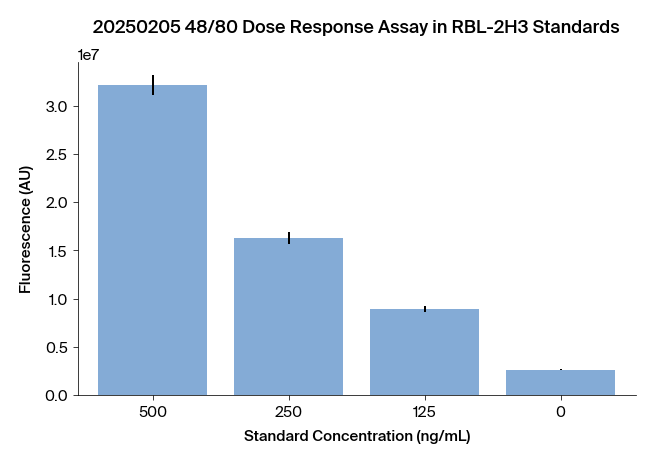

In [10]:
standards = labeled_df[standard_vals]

means = standards.mean()
std_devs = standards.std()

apc.mpl.setup()
plt.figure(figsize=(10, 6))
bars = plt.bar(means.index, means.values, yerr=std_devs.values, capsize=5, alpha=0.7)

# User can update labels and title as needed.
plt.xlabel("Standard Concentration (ng/mL)")
plt.ylabel("Fluorescence (AU)")
plt.title(experiment_name + " Standards")

plt.savefig(output_filename + "_standards.png", transparent=False)
plt.show()

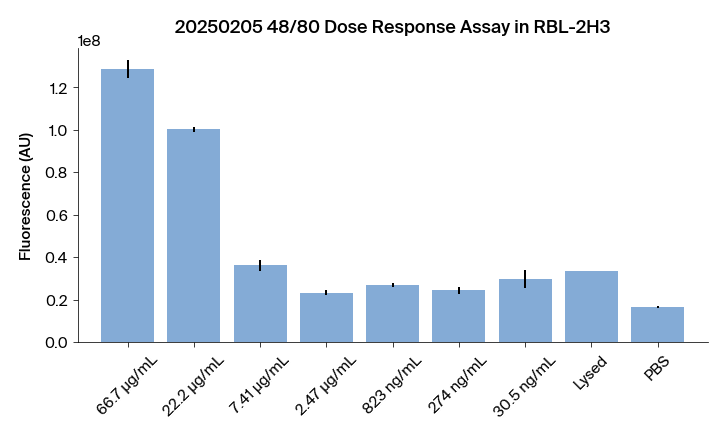

In [11]:
columns = labeled_df.columns.tolist()
sample_columns = [col for col in columns if col not in standards and col != blank]

samples = labeled_df[sample_columns]

sample_means = samples.mean()
sample_std_devs = samples.std()

apc.mpl.setup()
plt.figure(figsize=(10, 6))
bars = plt.bar(
    sample_means.index,
    sample_means.values,
    yerr=sample_std_devs.values,
    capsize=5,
    alpha=0.7,
)

# User can update labels and title as needed.
plt.ylabel("Fluorescence (AU)")
plt.title(experiment_name)

# Optionally adjust x-axis tick labels to avoid overlapping when plotting many samples.
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability.
plt.tight_layout()

plt.savefig(output_filename + "_samples.png", transparent=False)
plt.show()

In [20]:
# Data must be reshaped for statistical analysis.
samples_melt = samples.melt(var_name="Treatment", value_name="Concentration")
samples_melt = samples_melt.dropna(subset=["Concentration"])
samples_melt = samples_melt[samples_melt.groupby("Treatment")["Treatment"].transform("count") > 1]
samples_melt

,Treatment,Concentration
0,66.7 µg/mL,131767127.0
1,66.7 µg/mL,125584239.0
3,22.2 µg/mL,99325623.0
4,22.2 µg/mL,101056727.0
6,7.41 µg/mL,34204015.0
7,7.41 µg/mL,38084283.0
9,2.47 µg/mL,24050219.0
10,2.47 µg/mL,22608975.0
12,823 ng/mL,27696721.0
13,823 ng/mL,26204827.0


In [24]:
# One-way ANOVA is the most appropriate statistical test for these data.
anova_result = f_oneway(*(samples[col] for col in sample_columns))
print(f"ANOVA result: F-value = {anova_result.statistic}, p-value = {anova_result.pvalue}")

ANOVA result: F-value = nan, p-value = nan


In [25]:
# Tukey's HSD test is the most appropriate statistical test for post-hoc analysis.
tukey_result = pairwise_tukeyhsd(
    endog=samples_melt["Concentration"], groups=samples_melt["Treatment"], alpha=0.05
)
print(tukey_result)

tukey_df = pd.DataFrame(
    data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0]
)
tukey_df.to_csv(output_filename + "_tukey_hsd_results.csv", index=False)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
  group1     group2     meandiff   p-adj       lower           upper      reject
--------------------------------------------------------------------------------
2.47 µg/mL 22.2 µg/mL   76861578.0    0.0   66788667.0085   86934488.9915   True
2.47 µg/mL  274 ng/mL    1077672.0 0.9998   -8995238.9915   11150582.9915  False
2.47 µg/mL 30.5 ng/mL    6600353.0 0.2794   -3472557.9915   16673263.9915  False
2.47 µg/mL 66.7 µg/mL  105346086.0    0.0   95273175.0085  115418996.9915   True
2.47 µg/mL 7.41 µg/mL   12814552.0 0.0134    2741641.0085   22887462.9915   True
2.47 µg/mL  823 ng/mL    3621177.0 0.8257   -6451733.9915   13694087.9915  False
2.47 µg/mL        PBS   -6916028.5 0.2407  -16988939.4915    3156882.4915  False
22.2 µg/mL  274 ng/mL  -75783906.0    0.0  -85856816.9915  -65710995.0085   True
22.2 µg/mL 30.5 ng/mL  -70261225.0    0.0  -80334135.9915  -60188314.0085   True
22.2 µg/mL 66.7 µg/mL   2848

In [15]:
import sys

loaded_modules = {
    name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, "__version__")
}
print(loaded_modules)

{'re': '2.2.1', 'ipaddress': '1.0', 'ipykernel._version': '6.29.4', 'json': '2.0.9', 'jupyter_client._version': '8.6.2', 'platform': '1.0.8', 'zmq.sugar.version': '26.0.3', 'zmq.sugar': '26.0.3', 'zmq': '26.0.3', 'logging': '0.5.1.2', 'traitlets._version': '5.14.3', 'traitlets': '5.14.3', 'jupyter_core.version': '5.7.2', 'jupyter_core': '5.7.2', 'zlib': '1.0', '_curses': b'2.2', 'socketserver': '0.4', 'argparse': '1.1', 'dateutil._version': '2.9.0.post0', 'dateutil': '2.9.0.post0', 'six': '1.16.0', '_decimal': '1.70', 'decimal': '1.70', 'platformdirs.version': '4.2.2', 'platformdirs': '4.2.2', '_csv': '1.0', 'csv': '1.0', 'jupyter_client': '8.6.2', 'ipykernel': '6.29.4', 'IPython.core.release': '8.26.0', 'executing.version': '2.0.1', 'executing': '2.0.1', 'pure_eval.version': '0.2.2', 'pure_eval': '0.2.2', 'stack_data.version': '0.6.3', 'stack_data': '0.6.3', 'pygments': '2.18.0', 'decorator': '5.1.1', 'wcwidth': '0.2.13', 'prompt_toolkit': '3.0.47', 'parso': '0.8.4', 'jedi': '0.19.1',

/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_43078/3849240522.py:4: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.__version__.
  name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, "__version__")
